In [4]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.restoration import estimate_sigma
from src.communications_module.ofdm_modulator import OFDMModulator
from src.communications_module.channels.comm_channel import ChannelModel

In [5]:
rx_snrs_list = [-15, -10, -5, 0, 5, 10, 15]
subcarriers = 128
num_pilots = 8
bits_per_sym = 6
cp_ratio = 4

In [6]:
fading_channel = ChannelModel(total_carriers_over_ch=subcarriers,
                              channel_type='rayleigh_fading',
                              scaled_ch=True,
                              number_paths=7,
                              fc=990e6,
                              velocity=40,
                              k_rice=0,
                              r_hat_rice=2)

In [7]:
ofdm_gen = OFDMModulator(bits_per_sym=bits_per_sym, 
                         subcarriers=subcarriers, 
                         cp_ratio_numitor=cp_ratio, 
                         num_pilots=num_pilots, 
                         rx_snr=rx_snrs_list[0],
                         fading_channel=fading_channel)

allCarriers:   [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
pilotCarriers: [  0  16  32  48  64  80  96 112 127]
dataCarriers:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 103 10

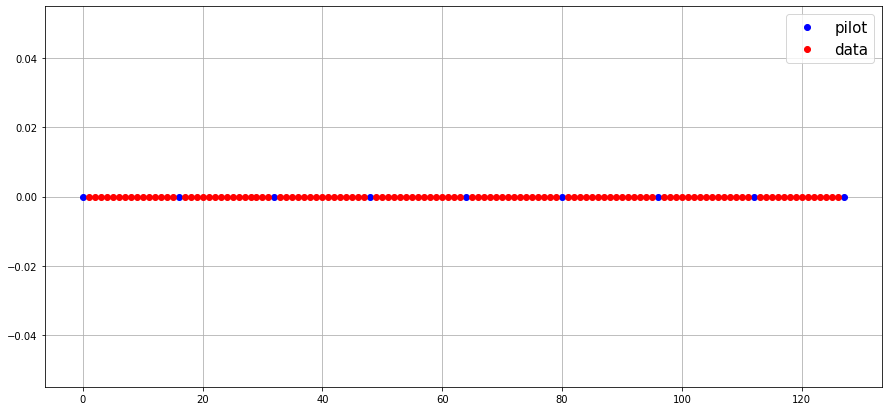

In [8]:
print ("allCarriers:   %s" % ofdm_gen.subcarriers_idxs)
print ("pilotCarriers: %s" % ofdm_gen.pilots_idxs)
print ("dataCarriers:  %s" % ofdm_gen.data_carriers_idxs)
plt.figure(figsize=(15, 7))
plt.plot(ofdm_gen.pilots_idxs, np.zeros_like(ofdm_gen.pilots_idxs), 'bo', label='pilot')
plt.plot(ofdm_gen.data_carriers_idxs, np.zeros_like(ofdm_gen.data_carriers_idxs), 'ro', label='data')
plt.legend(prop={'size': 15})
plt.grid()

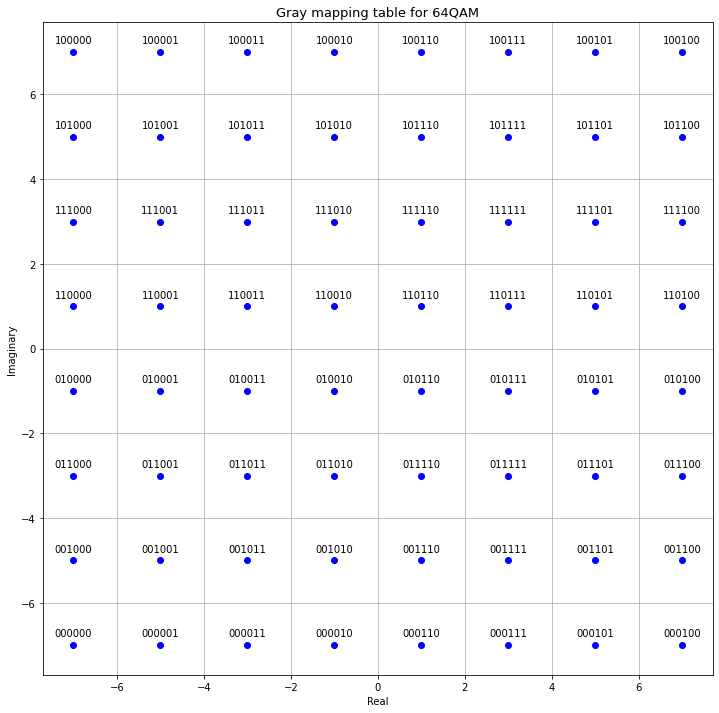

In [9]:
plt.figure(figsize=(12, 12))
plt.grid()
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title(f'Gray mapping table for {2**bits_per_sym}QAM', fontsize=13)
for key in ofdm_gen.mapping_table.keys():
    Q = ofdm_gen.mapping_table[key]
    plt.plot(Q.real, Q.imag, 'bo')
    plt.text(Q.real, Q.imag+0.2, "".join(str(key)), ha='center')

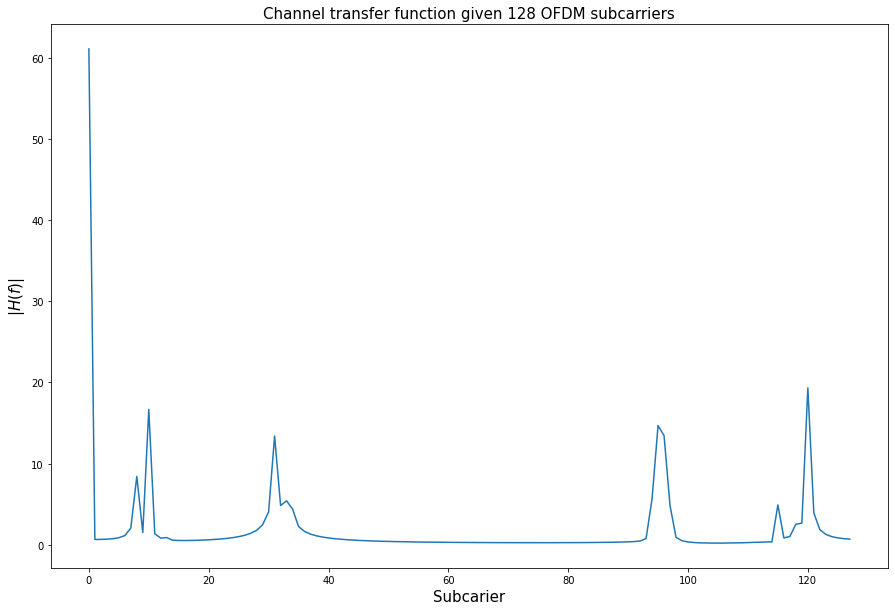

In [10]:
channelResponse = ofdm_gen.channel_response # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, ofdm_gen.subcarriers)
plt.figure(figsize=(15,10))
plt.plot(ofdm_gen.subcarriers_idxs, abs(H_exact))
plt.xlabel('Subcarier', fontsize=15); plt.ylabel('$|H(f)|$', fontsize=15);
plt.title(f'Channel transfer function given {subcarriers} OFDM subcarriers', fontsize=15)
SNRdb = 25  # signal to noise-ratio in dB at the receiver 

In [ ]:
ofdm_sign = np.array([])
for i in range(1000):
    payload, flag = ofdm_gen.generate_payload()
    print(payload, flag)
    qam_load = ofdm_gen.map_words_2_qam(payload)
    ofdm_sym = ofdm_gen.ofdm_symbol(qam_load, flag)
    ofdm_ift = ofdm_gen.ofdm_idft(ofdm_sym)
    if not flag:
        ofdm_wcp = ofdm_gen.add_cyclic_prefix(ofdm_ift)
        ofdm_sign = np.append(ofdm_wcp, ofdm_sign, 0)
    else:
        ofdm_sign = np.append(ofdm_ift, ofdm_sign, 0)
    # qam_load
print(ofdm_sign)

In [ ]:
ofdm_ift = ofdm_gen.ofdm_idft(ofdm_sign)
ofdm_wcp = ofdm_gen.add_cyclic_prefix(ofdm_ift)

In [ ]:
print(ofdm_sign.shape)

In [ ]:
OFDM_TX = ofdm_sign
OFDM_RX, noise = ofdm_gen.ofdm_over_channel(OFDM_TX)

In [ ]:
plt.figure(figsize=(20,10))
plt.title(
    f'Transmited and received OFDM signal over {fading_channel.channel_type.upper()} channel at SNR {rx_snrs_list[0]}dB',
         fontsize=15)
plt.plot(abs(noise[:2000]), label='Noise signal')
plt.plot(abs(OFDM_TX[:2000]), label='TX signal')
plt.plot(abs(OFDM_RX[:2000]), label='RX signal')
plt.legend(fontsize=10, prop={'size': 15})
plt.xlabel('Sample | Time', fontsize=15); plt.ylabel('$|x(t)|$', fontsize=15);
plt.grid(True);

In [ ]:
df['RX_OFDM'] = abs(OFDM_RX)
df['TX_OFDM'] = abs(OFDM_TX)
df.to_csv(f'E:/Faculta/Anul2/Disertatie/cognitive-aether/datasets/v2/rx_tx_ofdm.csv')

In [11]:
import pandas as pd
df = pd.DataFrame()

In [11]:
ch_type = 'rayleigh_fading'
fading_channel = ChannelModel(total_carriers_over_ch=subcarriers,
                              channel_type=ch_type,
                              scaled_ch=True,
                              number_paths=7,
                              fc=990e6,
                              velocity=50,
                              k_rice=0,
                              r_hat_rice=2)
for rx_snr in rx_snrs_list:
    ofdm_gen = OFDMModulator(bits_per_sym=bits_per_sym, 
                             subcarriers=subcarriers, 
                             cp_ratio_numitor=cp_ratio, 
                             num_pilots=num_pilots, 
                             rx_snr=rx_snr,
                             fading_channel=fading_channel)
    ofdm_sign = np.array([])
    for i in range(500):
        payload, flag = ofdm_gen.generate_payload()
#         print(payload, flag)
        qam_load = ofdm_gen.map_words_2_qam(payload)
        ofdm_sym = ofdm_gen.ofdm_symbol(qam_load, flag)
        ofdm_ift = ofdm_gen.ofdm_idft(ofdm_sym)
        ofdm_wcp = ofdm_gen.add_cyclic_prefix(ofdm_ift)
        ofdm_sign = np.append(ofdm_wcp, ofdm_sign, 0)
        # qam_load
    ofdm_ift = ofdm_gen.ofdm_idft(ofdm_sign)
    ofdm_wcp = ofdm_gen.add_cyclic_prefix(ofdm_ift)
    OFDM_TX = ofdm_sign
    OFDM_RX, noise = ofdm_gen.ofdm_over_channel(OFDM_TX)
    df['TX_OFDM'] = abs(OFDM_TX)
    df['RX_OFDM'] = abs(OFDM_RX)
    df['RX_POW_DB'] = np.log10(df['RX_OFDM']**2)
    df['noise'] = abs(noise)
    df['sigma'] = df['RX_OFDM'].rolling(100).apply(estimate_sigma)
    
    df = df.fillna(0)
    
    
    ones = df['TX_OFDM'] > 0
    df.loc[ones, 'USER'] = 1
    df.loc[~ones, 'USER'] = 0
    
    df.to_csv(f'E:/Faculta/Anul2/Disertatie/cognitive-aether/datasets/v2/{rx_snr}_{ch_type}_ofdm.csv', index=False)

Required signal power: 32.89693002754638 [W]=[V^2]
Initial signal power: 9.122860583407112 [W]=[V^2]
Signal amplitude rescale factor: 1.8989440393437185 [Volts]
RX Signal power: 32.8969. Noise power: 2.0112, SNR [dB]: 12.1370
Required signal power: 0.08513604725305396 [W]=[V^2]
Initial signal power: 9.049890358676576 [W]=[V^2]
Signal amplitude rescale factor: 0.09699181414121537 [Volts]
RX Signal power: 0.0851. Noise power: 1.9958, SNR [dB]: -13.7000
Required signal power: 0.634567124806636 [W]=[V^2]
Initial signal power: 9.95043100408252 [W]=[V^2]
Signal amplitude rescale factor: 0.25253282556069895 [Volts]
RX Signal power: 0.6346. Noise power: 2.0067, SNR [dB]: -5.0000
Required signal power: 1.9997719198412907 [W]=[V^2]
Initial signal power: 8.600879913222538 [W]=[V^2]
Signal amplitude rescale factor: 0.48219065672560313 [Volts]
RX Signal power: 1.9998. Noise power: 1.9998, SNR [dB]: 0.0000
Required signal power: 3.1587083186708456 [W]=[V^2]
Initial signal power: 9.887734283543338 [W